# Generating images using Stable Diffusion

> This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio and with the **`conda_python3`** in a SageMaker Notebook Instance.
> Source: https://github.com/aws-samples/amazon-bedrock-workshop/blob/main/04_Image_and_Multimodal/bedrock-stable-diffusionXL.ipynb

---

In this demo notebook, we show how to use [Stable Diffusion XL](https://stability.ai/stablediffusion) (SDXL) on [Amazon Bedrock](https://aws.amazon.com/bedrock/) for image generation (text-to-image) and image editing (image-to-image).

Images in Stable Diffusion are generated by these 4 main models below
1. The CLIP text encoder;
2. The VAE decoder;
3. The UNet, and
4. The VAE_post_quant_conv

These blocks are chosen because they represent the bulk of the compute in the pipeline

see this diagram below

![SD Architecture](./images/sd.png)

### Image prompting

Writing a good prompt can be somewhat of an art. It's often difficult to predict whether a certain prompt will yield a satisfactory image with a given model. However, there are certain templates that have been observed to work. Broadly, a prompt can be roughly broken down into three pieces:

1. **Type** of image (photograph/sketch/painting etc.)
2. **Description** of the content (subject/object/environment/scene etc.), and
3. **Style** of the image (realistic/artistic/type of art etc.).

You can change each of the three parts individually to generate variations of an image. Adjectives have been known to play a significant role in the image generation process. Also, adding more details help in the generation process.

To generate a realistic image, you can use phrases such as “a photo of”, “a photograph of”, “realistic” or “hyper realistic”. To generate images by artists you can use phrases like “by Pablo Piccaso” or “oil painting by Rembrandt” or “landscape art by Frederic Edwin Church” or “pencil drawing by Albrecht Dürer”. You can also combine different artists as well. To generate artistic image by category, you can add the art category in the prompt such as “lion on a beach, abstract”. Some other categories include “oil painting”, “pencil drawing, “pop art”, “digital art”, “anime”, “cartoon”, “futurism”, “watercolor”, “manga” etc. You can also include details such as lighting or camera lens such as 35mm wide lens or 85mm wide lens and details about the framing (portrait/landscape/close up etc.).

Note that model generates different images even if same prompt is given multiple times. So, you can generate multiple images and select the image that suits your application best.

## Setup

⚠️ ⚠️ ⚠️ Before running this notebook, ensure you've run the [Bedrock boto3 setup notebook](../00_Intro/bedrock_boto3_setup.ipynb#Prerequisites) notebook. ⚠️ ⚠️ ⚠️


In [1]:
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
from PIL import Image
import botocore

boto3_bedrock = boto3.client('bedrock-runtime')

## Text to Image

In text-to-image mode, we'll provide a text description of what image **should** be generated, called a `prompt`.

With Stable Diffusion XL (SDXL) we can also specify certain [style presets](https://platform.stability.ai/docs/release-notes#style-presets) to help influence the generation.

To further influence image generation, we make use of [clip guidance presets](https://platform.stability.ai/docs/features/api-parameters#clip_guidance) and [samplers](https://platform.stability.ai/docs/features/api-parameters#sampler) to get more desirable results. 

Although the current SDXL model defaults to a square [resolution](https://platform.stability.ai/docs/features/api-parameters#about-dimensions) of 512px x 512px, it is capable of generating images at higher resolutions and non-squared aspect ratios. As shown below, the `width` of the image was set to 768px and the `height` remains at its default value of 512px. 

But what if we want to nudge the model to ***avoid*** specific content or style choices? Because image generation models are typically trained from *image descriptions*, trying to directly specify what you **don't** want in the prompt (for example `man without a beard`) doesn't usually work well: It would be very unusual to describe an image by the things it isn't!

Instead, SDXL lets us specify a `weight` for each prompt, which can be negative. We'll use this to provide `negative_prompts` as shown below:

In [2]:
prompt = "a beautiful mountain landscape"
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "poorly drawn mountains",
    "disfigured mountain features",
]
style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
clip_guidance_preset = "FAST_GREEN" # (e.g. FAST_BLUE FAST_GREEN NONE SIMPLE SLOW SLOWER SLOWEST)
sampler = "K_DPMPP_2S_ANCESTRAL" # (e.g. DDIM, DDPM, K_DPMPP_SDE, K_DPMPP_2M, K_DPMPP_2S_ANCESTRAL, K_DPM_2, K_DPM_2_ANCESTRAL, K_EULER, K_EULER_ANCESTRAL, K_HEUN, K_LMS)
width = 768

The Amazon Bedrock `InvokeModel` provides access to SDXL by setting the right model ID, and returns a JSON response including a [Base64 encoded string](https://en.wikipedia.org/wiki/Base64) that represents the (PNG) image.

For more information on available input parameters for the model, refer to the [Stability AI docs](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/textToImage).

The cell below invokes the SDXL model through Amazon Bedrock to create an initial image string:

In [3]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 5,
    "seed": 42,
    "steps": 60,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
    "width": width,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAAEImVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


By decoding our Base64 string to binary, and loading it with an image processing library like [Pillow](https://pillow.readthedocs.io/en/stable/) that can read PNG files, we can display and manipulate the image here in the notebook:

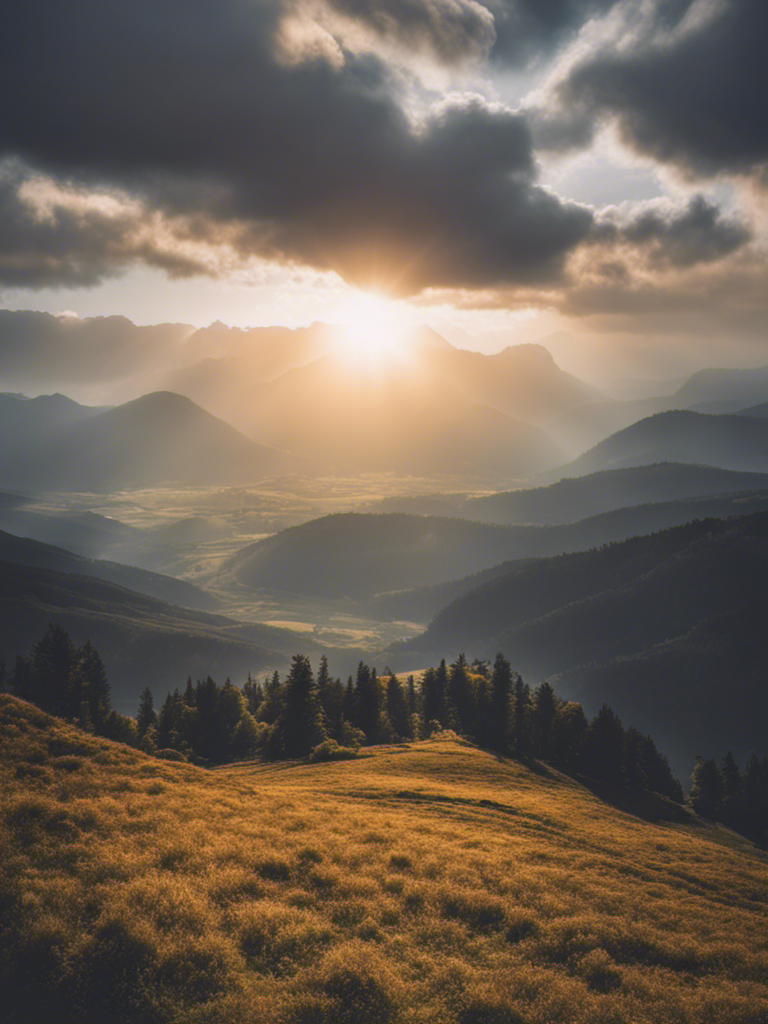

In [ ]:
os.makedirs("images", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("images/image_1.png")
image_1

## Image to Image

Generating images from text is powerful, but in some cases could need many rounds of prompt refinement to get an image "just right".

Rather than starting from scratch with text each time, image-to-image generation lets us **modify an existing image** to make the specific changes we'd like.

We'll have to pass our initial image in to the API in base64 encoding, so first let's prepare that. You can use either the initial image from the previous section, or a different one if you'd prefer:

In [5]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")


init_image_b64 = image_to_base64(image_1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAEAAElEQVR4nHz9TZMk17E0jLl7nMzqHgwG...


A new guiding prompt can then help the model to act on the intial image

In [6]:
change_prompt = "add denser number of trees, extend lake"

The existing image is then passed through to the Stable Diffusion model via the `init_image` parameter.

Again, you can refer to the [Stable Diffusion API docs](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/imageToImage) for more tips on how to use the different parameters:

In [7]:
request = json.dumps({
    "text_prompts": (
        [{"text": change_prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 321,
    "start_schedule": 0.6,
    "steps": 50,
    "style_preset": style_preset,
    "clip_guidance_preset": clip_guidance_preset,
    "sampler": sampler,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAHkxGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


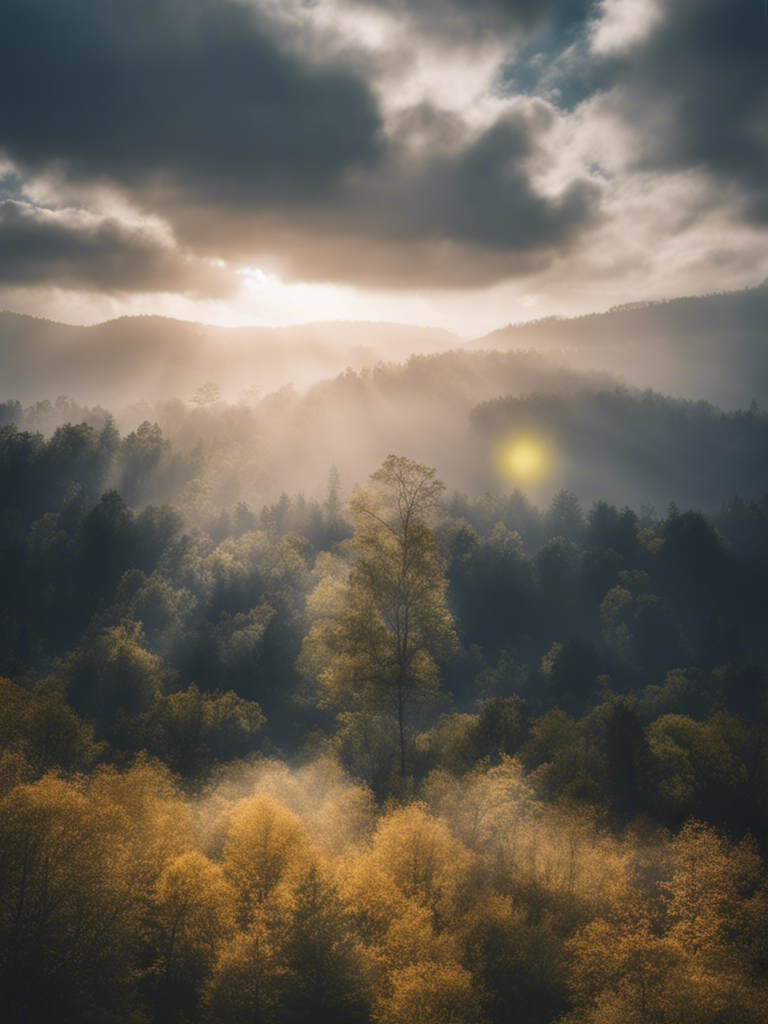

In [ ]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2.save("images/image_2.png")
image_2

### Image Inpainting

Yet another alternative to modify images is by using "inpainting". Inpainting refers to the process of replacing a portion of an image with another image based on a textual prompt. By providing a mask image that outlines the portion to be replaced, a textual prompt, and an image, the Stable Diffusion model can produce a new image that replaces the masked area with the object, subject, or environment described in the textual prompt.

You can use the mask provided in the `images/mask.png` file.

**Note**: The mask image is required to be the same resolution and aspect ratio as the image being inpainted upon. 

In [9]:
from PIL import ImageOps

def inpaint_mask(img, box):
    """Generates a segmentation mask for inpainting"""
    img_size = img.size
    assert len(box) == 4  # (left, top, right, bottom)
    assert box[0] < box[2]
    assert box[1] < box[3]
    return ImageOps.expand(
        Image.new(
            mode = "RGB",
            size = (
                box[2] - box[0],
                box[3] - box[1]
            ),
            color = 'black'
        ),
        border=(
            box[0],
            box[1],
            img_size[0] - box[2],
            img_size[1] - box[3]
        ),
        fill='white'
    )

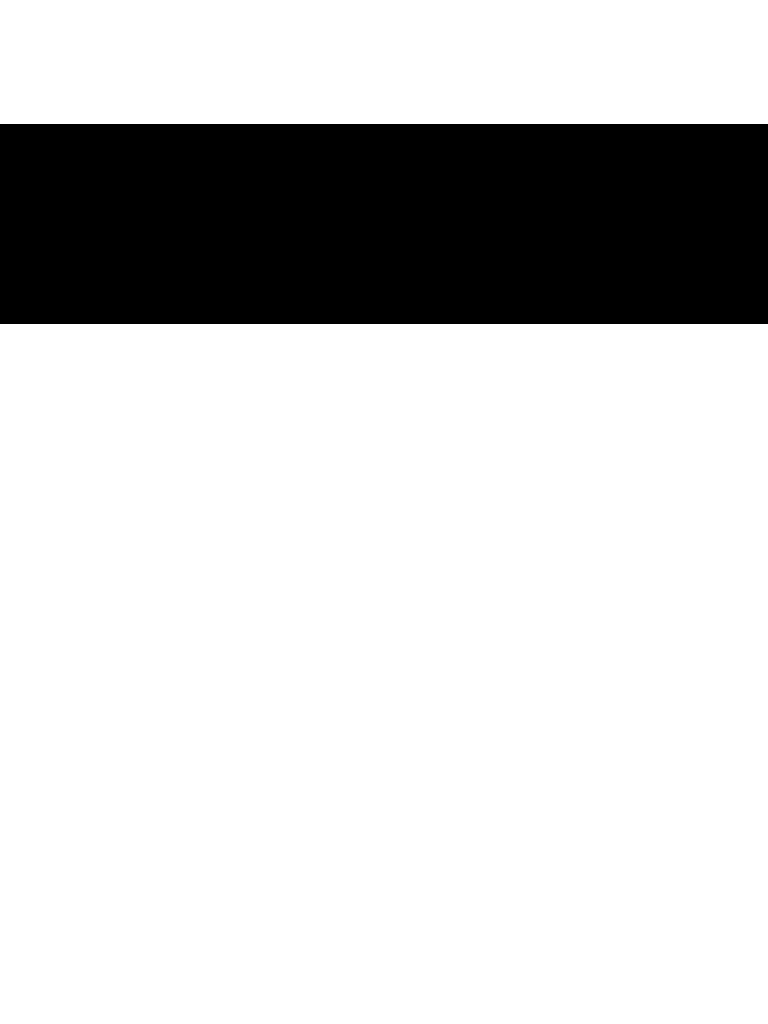

In [10]:
img2_size = image_2.size
box = (
        (0),
        (img2_size[1] - 900) ,
        (img2_size[0]),
        img2_size[1] - 700
    )

# Mask
mask = inpaint_mask(
    image_2,
    box
)

# Debug
mask

We will now define what we want to change in the image.

In [11]:
inpaint_prompt = "add a helicopter"

Similarly to what we did before, we will the pass the previously generated image through to the Stable Diffusion model via the `init_image` parameter.

This time, we will also specify the `mask_source` parameter to pass the mask. 

You can refer to the [Stable Diffusion API docs](https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/imageToImage) for more tips on how to use the different parameters:

In [12]:
request = json.dumps({
    "text_prompts":[{"text": inpaint_prompt}],
    "init_image": image_to_base64(image_2),
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask),
    "cfg_scale": 10,
    "seed": 32123,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl-v1"

response = boto3_bedrock.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_3_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

Converting PIL Image to base64 string
Converting PIL Image to base64 string
success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAQACAIAAADZRKlXAAHkxGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


Lets show the image we just modified:

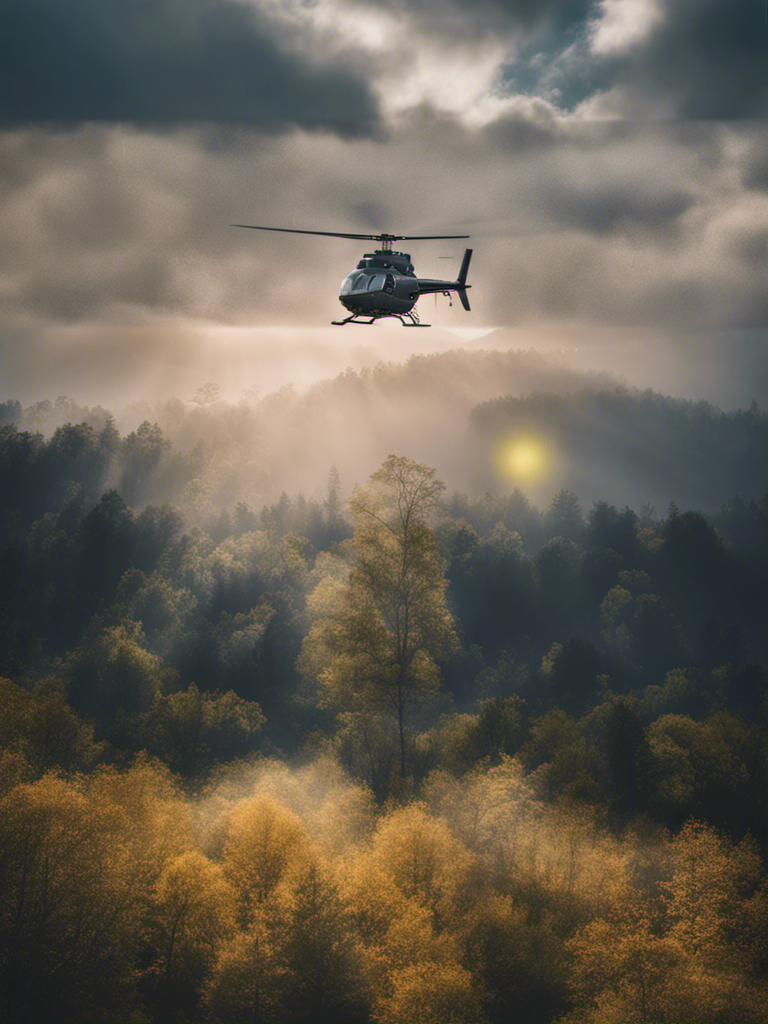

In [ ]:
os.makedirs("images", exist_ok=True)
inpaint = Image.open(io.BytesIO(base64.decodebytes(bytes(image_3_b64_str, "utf-8"))))
inpaint.save("images/inpaint.png")
inpaint

## Summary

In this lab we demonstrated how to generate new images from text, and transform existing images with text instructions - using [Stable Diffusion XL](https://stability.ai/stablediffusion) on [Amazon Bedrock](https://aws.amazon.com/bedrock/).

Through the Bedrock API, we can provide a range of parameters to influence image generation which generally correspond to those listed in the [Stable Diffusion API docs](https://platform.stability.ai/docs/api-reference#tag/v1generation).

One key point to note when using Bedrock is that output image PNG/JPEG data is returned as a [Base64 encoded string](https://en.wikipedia.org/wiki/Base64) within the JSON API response: You can use the Python built-in [base64 library](https://docs.python.org/3/library/base64.html) to decode this image data - for example to save a `.png` file. We also showed that image processing libraries like [Pillow](https://pillow.readthedocs.io/en/stable/) can be used to load (and perhaps edit) the images within Python.

From here you can explore more advanced image generation options - or combine GenAI with traditional image processing tools - to build the best creative workflow for your use-case.